In [45]:
import processing
import models
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
import torch
import json
import configs.common as cc


In [46]:
train_dataloader, test_dataloader = processing.get_train_test_dataloaders('F:\\GitHub\\dataset\\np_dataset')


In [47]:
total = torch.tensor([], device='cuda')
for batch_idx, (src, trg, metadata) in enumerate(train_dataloader):
    total = torch.concat((total, src.flatten()))

<BarContainer object of 835 artists>

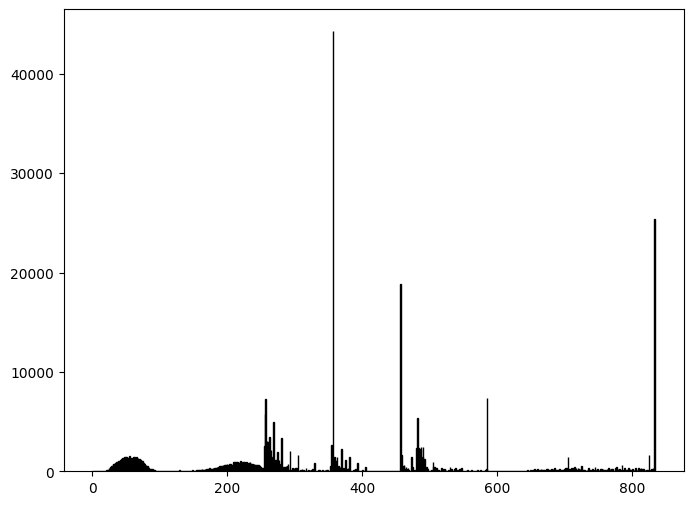

In [48]:
flattened_tensor = total.int()
bins = cc.vocab_size
hist = torch.histc(flattened_tensor, bins=bins, min=0, max=cc.vocab_size)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(range(bins), hist.cpu().int().numpy(), width=1, align='center', color='blue', edgecolor='black')


In [55]:
print(hist[357] / len(flattened_tensor) * 100)


tensor(11.9597, device='cuda:0')
